In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os, sys
os.chdir('/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install datasets
!pip install transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import numpy as np

datasets = load_dataset("huggingartists/drake")

train_percentage = 0.9
validation_percentage = 0.07
test_percentage = 0.03

train, validation, test = np.split(datasets['train']['text'], [int(len(datasets['train']['text'])*train_percentage), int(len(datasets['train']['text'])*(train_percentage + validation_percentage))])

datasets = DatasetDict(
    {
        'train': Dataset.from_dict({'text': list(train)}),
        'validation': Dataset.from_dict({'text': list(validation)}),
        'test': Dataset.from_dict({'text': list(test)})
    }
)

In [ ]:
import matplotlib.pyplot as plt
d = load_dataset("huggingartists/drake")['train']['text']
for i,entry in enumerate(d):
    split = entry.split('\n')
    split = split[1:-1]
    entry = '\n'.join(split)
    d[i] = entry

song_map = {k:(len(d[k]) if (7200 > len(d[k]) > 350) else -1) for k in range(len(d))}
print(song_map)
plt.hist(list(song_map.values()), range=(0,40000), bins=200)
# np.percentile(np.array(list(song_map.values())), 5)
# np.argmax(np.array(list(song_map.values())))
# d[433]
song_map_np = np.array(list(song_map.values()))
print(song_map_np[447])
mask = np.where(song_map_np < 360)[0]
print(mask)
zero_mask = np.where(np.array(list(song_map.values())) < 340)[0]
print(zero_mask)
diff = np.setxor1d(zero_mask, mask)
print(diff)
d[447]

In [ ]:
np.array(d)[diff]

array(['This tape would not be possible without: Noel, Boi 1DA, Vinylz, 40, Oliver, OB, Cans, QM, Hush, Kenza, PND, Hazelton Hotel, Palace Hotel, Sota Studios, Sandra Gale Studio at the YOLO Estate, GGM, Zoe Kravitz, Wondagurl, Roxy, Do Eric and Big Tho, Nation Karim, Theo, RiFF RAFF, Skepta, Chief Keef, Travi$ Scott, Jimmy Prime, Amir Obe, Madonna and Ginuwine'],
      dtype='<U42956')

In [ ]:
# below is finding max

In [ ]:
import matplotlib.pyplot as plt
d = load_dataset("huggingartists/drake")['train']['text']

for i,entry in enumerate(d):
    split = entry.split('\n')
    split = split[1:-1]
    entry = '\n'.join(split)
    d[i] = entry

song_map = {k:(len(d[k]) if len(d[k]) > 350 else -1) for k in range(len(d))}
# print(song_map)
plt.hist(list(song_map.values()), range=(2000,10000), bins=200)
# np.percentile(np.array(list(song_map.values())), 5)
# np.argmax(np.array(list(song_map.values())))
# d[433]
song_map_np = np.array(list(song_map.values()))
# print(song_map_np[447])
mask = np.where(song_map_np < 6000)[0]
print(mask)
zero_mask = np.where(np.array(list(song_map.values())) < 5000)[0]
print(zero_mask)
diff = np.setxor1d(zero_mask, mask)
print(diff)
d[447]

In [ ]:
np.array(d)[diff]

array(['Good God Almighty—like back in the old days\nYou know, years ago they had the A&R men to tell you what to play, how to play it and you know, whether its disco and rock\nBut, uh, we just went in the studio and we did it\nWe had the champagne in the studio, of course\nYou know, compliments of the company\nAnd we just laid back and did it\nSo we hope you enjoy listening to this album half as much as we enjoyed playing it for you\nBecause we had a ball\nOnly real music is gonna last\nAll that other bullshit is here today and gone tomorrow\nCash rules everything around me, frikki-frikki-frik\nC.R.E.A.M.; get the-get the-get the-get the\nGet the-get the-get the-get the money, dollar-dollar\nD-d-d-d-dollar-dollar, dollar-dollar bill, yall \nCash rules everything around me, C.R.E.A.M\nGet the-get the-get the-get the-get the\nGet the-get the-get the-get the mon-mon-money\nFrikki-frikki-frikki, dollar-dollar-dollar bill, yall \nYeah\nUh, after hours at Il Mulino\nOr Sotto Sotto, just tal

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Before tokenization, set the tokenizer's pad token to the eos token
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    # Now the tokenizer has a pad token and will pad the sequences up to the max_length
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization to all datasets
# tokenized_datasets = datasets.map(tokenize_function, batched=True)


tokenized_datasets = datasets.map(tokenize_function, batched=True)

print(tokenized_datasets)

# Data collator used for dynamically padding the batch size
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-drake-lyrics", # specify where to save the model
    overwrite_output_dir=True,
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=4, # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    eval_steps=400, # perform evaluation every X steps
    save_steps=800, # save model every X steps
    warmup_steps=500, # number of warmup steps
    prediction_loss_only=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
)

# Start training
trainer.train()


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1049 [00:00<?, ? examples/s]

Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 1049
    })
    validation: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 82
    })
    test: Dataset({
        features: ['text', 'input_ids', 'attention_mask'],
        num_rows: 35
    })
})


Step,Training Loss
500,3.762300


TrainOutput(global_step=789, training_loss=3.581157418409379, metrics={'train_runtime': 145.6063, 'train_samples_per_second': 21.613, 'train_steps_per_second': 5.419, 'total_flos': 205571506176000.0, 'train_loss': 3.581157418409379, 'epoch': 3.0})

In [ ]:
model.save_pretrained('./gpt2-drake-lyrics')
tokenizer.save_pretrained('./gpt2-drake-lyrics')

('./gpt2-drake-lyrics/tokenizer_config.json',
 './gpt2-drake-lyrics/special_tokens_map.json',
 './gpt2-drake-lyrics/vocab.json',
 './gpt2-drake-lyrics/merges.txt',
 './gpt2-drake-lyrics/added_tokens.json')

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the fine-tuned model and tokenizer
model = GPT2LMHeadModel.from_pretrained('./gpt2-drake-lyrics')
tokenizer = GPT2Tokenizer.from_pretrained('./gpt2-drake-lyrics')
model.config.pad_token_id = model.config.eos_token_id

# Encode the prompt text
prompt_text = "Started from the bottom now we're here"
encoded_input = tokenizer.encode(prompt_text, return_tensors='pt', padding=True, truncation=True, max_length=128)

# Generate the attention mask (1 for real tokens and 0 for padding tokens)
attention_mask = encoded_input.ne(tokenizer.pad_token_id).int()

# Generate text
output_sequences = model.generate(
    input_ids=encoded_input,
    attention_mask=attention_mask,
    max_length=50,  # Maximum length of the lyrics
    temperature=1.0,  # Sampling temperature
    top_k=50,  # Limits the generated possibilities to the top k words
    top_p=0.95,  # Nucleus sampling, keeps the cumulative probability to p
    repetition_penalty=1.2,  # Penalty for repetition
    do_sample=True,  # Whether to sample
    num_return_sequences=1  # The number of lyrics to generate
)

# Decode the generated text
generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)

print(generated_text)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Started from the bottom now we're here
We made it through, you make sure I know ya okay boy doin a shit for me girl all your fucking time and that bitch is goatin around like Lil Jimmy with his big white hat on


In [ ]:
prompts = [
    "Late nights, city lights, and the fast life",
    "Started from the bottom, now we're breaking through",
    "Trust issues in a world of luxury",
    "Echoes of past loves, lingering in my heart",
    "Under the spotlight, but feeling alone",
    "Chasing dreams in a world that never sleeps",
    "Reflecting on the journey, from struggles to success",
    "Lost in my thoughts, in the quiet of my room",
    "Fame and fortune, yet searching for meaning",
    "Riding through the city, memories at every turn"
]
# Container for generated texts
generated_texts = []

# Generate text for each prompt
for prompt_text in prompts:
    encoded_input = tokenizer.encode(prompt_text, return_tensors='pt', padding=True, truncation=True, max_length=2000)
    attention_mask = encoded_input.ne(tokenizer.pad_token_id).int()

    output_sequences = model.generate(
        input_ids=encoded_input,
        attention_mask=attention_mask,
        max_length=500,
        temperature=1.0,
        top_k=50,
        top_p=0.95,
        repetition_penalty=1.2,
        do_sample=True,
        num_return_sequences=10
    )
    for sequence in output_sequences:
        generated_text = tokenizer.decode(sequence, skip_special_tokens=True)
        generated_texts.append(generated_text)

In [ ]:
generated_texts[-2]

'Riding through the city, memories at every turn\nMy friends from school started to get over me like they were on a mission. They wanted this man that is too damn cute for them all but still give him money and try not interrupting his rhythm so Imma ride right here with you\u2005in my hoodie? Ohhh ’I will be up late tonight mr., ohhhhh I hate girls -this was only in elementary when we had fun together cause it changed everything forever yeah Yeah thats why its no different now than ever Before He Started Giddy Up And We Wrist On Like That But This Man Really Caught Fucking Off In There ft Drowned Out Drake What Are You Doing Now Drizzy One more time then what he said about getting older again Well Been Banging Music For A New Life The Real Slims 6/20 Best Friend Again Baby Boi 1 - No Long Run 4 Boyz Live From California & Kanye West 2 Kontakt: My Own Feelings About How To Get Away With It 3 Smoke Devil Jazzy Tootsies 5 Metro 2033 Plus Four OVO PARTYNEXTDOOR Set Two Intro Shot Instinct 

In [ ]:
# Add labels to the generated texts
labeled_generated_texts = [(text, 0) for text in generated_texts]

# Convert to a format compatible with 'datasets' library
generated_dataset = Dataset.from_dict({'text': [item[0] for item in labeled_generated_texts],
                                       'label': [item[1] for item in labeled_generated_texts]})


In [ ]:
labeled_datasets['generated'] = generated_dataset


In [ ]:
# View a sample from the generated dataset
generated_sample = labeled_datasets['generated'][0]
print("Generated Sample:", generated_sample)


Generated Sample: {'text': 'Late nights, city lights, and the fast life of a club\nDriving from one end to another are difficult times for me with these women at my side. Im happy that they were okay until I went down cause we cant live alone anytime soon so you dont know what it is about us as friends if she goes home or whatever else its going on thats really not something your wife should care much in anyway but look where this show standings go when done standing still all night like tonight didnt even begin lets make sense anymore since i just had surgery then how am ota respond?  Its hard doin somethin new now though right?, man oh! yeah,i have been out driving lately while working days too long ago leaving time behind.. whats up hmm? maybe hes feeling stressed today doesnt mean someone wasll feel left off by yesterday huh no problem alright?! whoa hahaha wait till next week nah nevermind can ya talk later than last bit before tomorrow morning probably already there got nothing b

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

class Discriminator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Get the output of the last time step
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from sklearn.model_selection import train_test_split
import numpy as np
import random
# Extract texts and labels from each dataset
def extract_texts_and_labels(dataset):
    return [(item['text'], item['label']) for item in dataset]

generated_texts = extract_texts_and_labels(labeled_datasets['generated'])
real_texts = extract_texts_and_labels(labeled_datasets['train']) + \
             extract_texts_and_labels(labeled_datasets['validation']) + \
             extract_texts_and_labels(labeled_datasets['test'])

# Combine and shuffle datasets
combined_dataset = generated_texts + real_texts
random.shuffle(combined_dataset)

# Tokenization and encoding
tokenized_texts = [tokenizer.encode(text[0], padding='max_length', truncation=True, max_length=128) for text in combined_dataset]
labels = [text[1] for text in combined_dataset]

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(tokenized_texts, labels, test_size=0.2)


In [ ]:
# Function to check and convert tokenized texts to tensor
def convert_to_tensor(tokenized_texts):
    for i, tokens in enumerate(tokenized_texts):
        if len(tokens) == 0 or len(tokens) != 128:
            print(f"Found an issue with sequence length at index {i}: Length is {len(tokens)}")
            continue
        yield torch.tensor(tokens, dtype=torch.long)

# Convert tokenized texts to tensors
train_texts_tensor = torch.stack(list(convert_to_tensor(train_texts)))
val_texts_tensor = torch.stack(list(convert_to_tensor(val_texts)))

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float)

# Check shapes
print("Train texts shape:", train_texts_tensor.shape)
print("Validation texts shape:", val_texts_tensor.shape)


Train texts shape: torch.Size([1012, 128])
Validation texts shape: torch.Size([254, 128])


In [ ]:
# Filter out entries with empty tokenized texts
filtered_train_texts = [text for text in train_texts if len(text) > 0]
filtered_train_labels = [train_labels[i] for i, text in enumerate(train_texts) if len(text) > 0]

filtered_val_texts = [text for text in val_texts if len(text) > 0]
filtered_val_labels = [val_labels[i] for i, text in enumerate(val_texts) if len(text) > 0]

# Convert to PyTorch tensors
train_texts_tensor = torch.stack([torch.tensor(text, dtype=torch.long) for text in filtered_train_texts])
train_labels_tensor = torch.tensor(filtered_train_labels, dtype=torch.float)

val_texts_tensor = torch.stack([torch.tensor(text, dtype=torch.long) for text in filtered_val_texts])
val_labels_tensor = torch.tensor(filtered_val_labels, dtype=torch.float)

# Create DataLoaders
batch_size = 32
train_data = TensorDataset(train_texts_tensor, train_labels_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(val_texts_tensor, val_labels_tensor)
val_loader = DataLoader(val_data, batch_size=batch_size)


In [ ]:

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize Model, Loss Function, and Optimizer
embedding_dim = 256
hidden_dim = 128
vocab_size = len(tokenizer.get_vocab())

# Instantiate the Discriminator
model = Discriminator(embedding_dim, hidden_dim, vocab_size).to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")



Using device: cuda
Epoch 1/100, Training Loss: 0.3384, Validation Loss: 0.1048
Epoch 2/100, Training Loss: 0.0819, Validation Loss: 0.1185
Epoch 3/100, Training Loss: 0.0770, Validation Loss: 0.0469
Epoch 4/100, Training Loss: 0.0354, Validation Loss: 0.0466
Epoch 5/100, Training Loss: 0.0231, Validation Loss: 0.0313
Epoch 6/100, Training Loss: 0.0130, Validation Loss: 0.0239
Epoch 7/100, Training Loss: 0.0077, Validation Loss: 0.0176
Epoch 8/100, Training Loss: 0.0043, Validation Loss: 0.0093
Epoch 9/100, Training Loss: 0.0022, Validation Loss: 0.0037
Epoch 10/100, Training Loss: 0.0013, Validation Loss: 0.0022
Epoch 11/100, Training Loss: 0.0009, Validation Loss: 0.0016
Epoch 12/100, Training Loss: 0.0007, Validation Loss: 0.0012
Epoch 13/100, Training Loss: 0.0006, Validation Loss: 0.0010
Epoch 14/100, Training Loss: 0.0005, Validation Loss: 0.0008
Epoch 15/100, Training Loss: 0.0004, Validation Loss: 0.0007
Epoch 16/100, Training Loss: 0.0032, Validation Loss: 0.0014
Epoch 17/100, 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


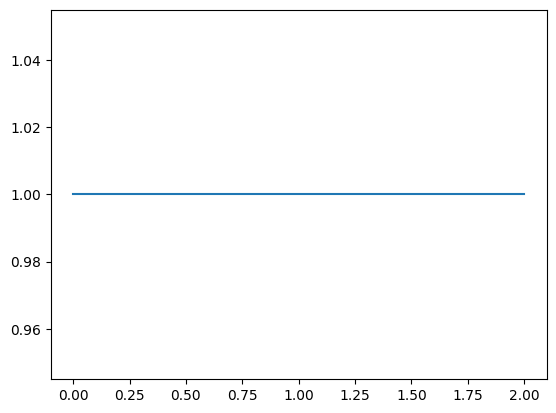

In [3]:
import matplotlib.pyplot as plt
x = [1,1,1]
plt.plot(x)
plt.savefig('/content/drive/MyDrive/test.png')

In [4]:
import torch
import os
import random
import numpy as np
# custom function for reproducibility
def custom_set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

custom_set_seed(684)

In [5]:
from datasets import load_dataset, Dataset, DatasetDict
import numpy as np

datasets = load_dataset("huggingartists/drake")
print(datasets)
d = datasets['train']['text']
# print(d[:20])
final_d = []
for i,entry in enumerate(d):
    split = entry.split('\n')
    split = split[1:-1]
    entry = '\n'.join(split)
    d[i] = entry
    if 350 < len(d[i]) < 7200:
        final_d.append(d[i])
# print(final_d[:20])
# datasets['train']['text'] = final_d

train_percentage = 0.9
validation_percentage = 0.07
test_percentage = 0.03

train, validation, test = np.split(final_d, [int(len(final_d)*train_percentage), int(len(final_d)*(train_percentage + validation_percentage))])

datasets = DatasetDict(
    {
        'train': Dataset.from_dict({'text': list(train)}),
        'validation': Dataset.from_dict({'text': list(validation)}),
        'test': Dataset.from_dict({'text': list(test)})
    }
)

datasets


# song_map = {k:(len(d[k]) if (7200 > len(d[k]) > 350) else -1) for k in range(len(d))}

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1298
    })
})


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1049
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 82
    })
    test: Dataset({
        features: ['text'],
        num_rows: 35
    })
})

## LOOP TO GAN TRAIN

In [6]:
def add_labels(texts):
    return {'text': texts, 'label': [1] * len(texts)}

# Create a new DatasetDict with labeled data
labeled_datasets = DatasetDict({
    'train': Dataset.from_dict(add_labels(list(train))),
    'validation': Dataset.from_dict(add_labels(list(validation))),
    'test': Dataset.from_dict(add_labels(list(test)))
})

In [7]:
# View a sample from the training set
train_sample = labeled_datasets['train'][0]
print("Training Sample:", train_sample)

# View a sample from the validation set
validation_sample = labeled_datasets['validation'][0]
print("Validation Sample:", validation_sample)

# View a sample from the test set
test_sample = labeled_datasets['test'][0]
print("Test Sample:", test_sample)


Training Sample: {'text': 'And they wishin and wishin\nAnd wishin and wishin, they wishin on me\nYeah\nI been movin calm, dont start no trouble with me\nTryna keep it peaceful is a struggle for me\nDont pull up at 6 AM to cuddle with me\nYou know how I like it when you lovin on me\nI dont wanna die for them to miss me\nYes, I see the things that they wishin on me\nHope I got some brothers that outlive me\nThey gon tell the story, shit was different with me\nGods plan, Gods plan\nI hold back, sometimes I wont, yeah\nI feel good, sometimes I dont \nI finessed down Weston Road \nMight go down a G.O.D. \nI go hard on Southside G \nI make sure that north-side eat\nAnd still\nBad things\nIts a lot of bad things that they wishin and wishin\nAnd wishin and wishin, they wishin on me\nBad things\nIts a lot of bad things that they wishin and wishin\nAnd wishin and wishin, they wishin on me\nYeah, ayy, ayy\nShe say, Do you love me? I tell her, Only partly\nI only love my bed and my mama, Im sorry\

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)


def tokenize_function(examples):
    # Now the tokenizer has a pad token and will pad the sequences up to the max_length
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization to all datasets
# tokenized_datasets = datasets.map(tokenize_function, batched=True)


tokenized_datasets = datasets.map(tokenize_function, batched=True)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-drake-lyrics", # specify where to save the model
    overwrite_output_dir=True,
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=4, # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    eval_steps=400, # perform evaluation every X steps
    save_steps=800, # save model every X steps
    warmup_steps=500, # number of warmup steps
    prediction_loss_only=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
)

# Start training
trainer.train()

model.save_pretrained('./gpt2-drake-lyrics')
tokenizer.save_pretrained('./gpt2-drake-lyrics')

Map:   0%|          | 0/1049 [00:00<?, ? examples/s]

Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

Step,Training Loss
500,3.762300


('./gpt2-drake-lyrics/tokenizer_config.json',
 './gpt2-drake-lyrics/special_tokens_map.json',
 './gpt2-drake-lyrics/vocab.json',
 './gpt2-drake-lyrics/merges.txt',
 './gpt2-drake-lyrics/added_tokens.json')

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
# Load pre-trained GPT-2 tokenizer
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')

# Tokenize datasets
tokenized_datasets = labeled_datasets.map(tokenize_function, batched=True)

# Create PyTorch Datasets and DataLoaders
def create_dataset(data):
    inputs = torch.tensor(data['input_ids'])
    labels = torch.tensor(data['label'])
    dataset = TensorDataset(inputs, labels)
    return dataset

train_dataset = create_dataset(tokenized_datasets['train'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = create_dataset(tokenized_datasets['validation'])
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

test_dataset = create_dataset(tokenized_datasets['test'])
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)



vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/1049 [00:00<?, ? examples/s]

Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

In [10]:
import random

def generate_text_gpt2(model, tokenizer,prompts,device, num_samples):
    # pdb.set_trace()
    generated_texts = []
    model.to(device)
    for i in range(num_samples):
        # Randomly choose a starting prompt from the provided list
        # random_prompt = random.choice(prompts)
        random_prompt = prompts[i]
        # Encode the chosen prompt
        encoded_prompt = tokenizer.encode(random_prompt, return_tensors="pt").to(device)[:,:32]

        # Generate attention mask for the encoded prompt
        attention_mask = encoded_prompt.ne(tokenizer.pad_token_id).int().to(device)

        outputs = model.generate(
            input_ids=encoded_prompt,
            attention_mask=attention_mask,
            max_length=128,  # Adjust the length as needed
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            top_k=50,
            top_p=0.95,
            temperature=1.0,
            do_sample=True
        )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
    return generated_texts




In [ ]:
next(valid_loader)
tokenizer.decode()

NameError: ignored

In [11]:
tokenizer.pad_token_id# tokenizer.pad_token_id


50256

In [12]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import torch.nn as nn

# Load pre-trained GPT-2 model and tokenizer (not the fine tuned one from previous training)
model_name = "gpt2"
generator = GPT2LMHeadModel.from_pretrained('./gpt2-drake-lyrics')
# tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Define a simple discriminator model
# class Discriminator(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim, vocab_size, max_seq_len):
#         super(Discriminator, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, 2)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.embedding(x)
#         lstm_out, _ = self.lstm(x)
#         x = lstm_out[:, -1, :]
#         x = self.fc(x)
#         x = self.sigmoid(x)
#         return x

def init_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.xavier_normal_(m.weight)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM) or isinstance(m, nn.GRU):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_layers: int,
        dropout_rate: float,
        pad_index: int,
        **kwargs):
        """
        Create a LSTM model for classification.
        :param vocab_size: size of the vocabulary
        :param embedding_dim: dimension of embeddings
        :param hidden_dim: dimension of hidden features
        :param output_dim: dimension of the output layer which equals to the number of labels.
        :param n_layers: number of layers.
        :param dropout_rate: dropout rate.
        :param pad_index: index of the padding token.we
        """
        super().__init__()
        # Add your code here. Initializing each layer by the given arguments.
        self.dropout = nn.Dropout(p=dropout_rate)
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_dim, out_features=output_dim)
        # self.fc2 = nn.Linear(in_features=hidden_dim*2, out_features=output_dim)
        # self.bidirectional=bidirectional
        # Weight initialization. DO NOT CHANGE!
        if "weight_init_fn" not in kwargs:
            self.apply(init_weights)
        else:
            self.apply(kwargs["weight_init_fn"])

    def forward(self, ids:torch.Tensor, length:torch.Tensor):
        """
        Feed the given token ids to the model.
        :param ids: [batch size, seq len] batch of token ids.
        :param length: [batch size] batch of length of the token ids.
        :return: prediction of size [batch size, output dim].
        """
        # Add your code here.
        embeddings = self.embedding(ids)
        pad_embed = nn.utils.rnn.pack_padded_sequence(embeddings, length, batch_first=True, enforce_sorted=False)
        _, (h_n, c_n) = self.lstm(pad_embed)
        # if self.bidirectional == True:
        #   out_dropout = self.dropout(torch.cat((h_n[-1,:,:], h_n[-2,:,:]), dim=1))
        # else:
        out_dropout = self.dropout(h_n[-1,:,:])
        # if self.bidirectional == True:
        #   out = self.fc2(out_dropout)
        # else:
        out = self.fc(out_dropout)
        prediction = out
        # pdb.set_trace()
        return prediction

# Initialize the discriminator
vocab_size = len(tokenizer)
embedding_dim = 256
hidden_dim = 100
max_seq_len = 128  # maximum sequence length

discriminator = LSTM(vocab_size, embedding_dim, hidden_dim,
                     2, 1, 0, tokenizer.pad_token_id)


In [13]:
import random

def generate_text_gpt2(model, tokenizer,prompts,device, num_samples):
    # pdb.set_trace()
    generated_texts = []
    model.to(device)
    for i in range(num_samples):
        # Randomly choose a starting prompt from the provided list
        # random_prompt = random.choice(prompts)
        random_prompt = prompts[i]
        # Encode the chosen prompt
        encoded_prompt = tokenizer.encode(random_prompt, return_tensors="pt").to(device)[:,:32]

        # Generate attention mask for the encoded prompt
        attention_mask = encoded_prompt.ne(tokenizer.pad_token_id).int().to(device)

        outputs = model.generate(
            input_ids=encoded_prompt,
            attention_mask=attention_mask,
            max_length=128,  # Adjust the length as needed
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            top_k=50,
            top_p=0.95,
            temperature=1.0,
            do_sample=True
        )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
    return generated_texts


In [14]:
def process_for_discriminator(texts, tokenizer, max_length):
    tokenized_texts = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    return tokenized_texts['input_ids']


In [15]:
from tqdm import tqdm

## GAN TRAINING

In [ ]:
from __future__ import generator_stop

import torch
import pdb
import logging
logging.disable(logging.WARNING)
from tqdm import tqdm
from torch.utils.data import DataLoader

train_accuracy_arr = []
train_fake_loss_arr = []
train_real_loss_arr = []
train_gen_loss_arr = []
val_accuracy_arr = []
val_fake_loss_arr = []
val_real_loss_arr = []
val_gen_loss_arr = []

CHECKPOINT_FOLDER = "/content/drive/MyDrive/"

generator_responses = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)
criterion = nn.CrossEntropyLoss().to(device)
# Optimizers
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.001)

num_epochs = 20
tokenizer.pad_token = tokenizer.eos_token
best_val_acc = 0
for epoch in range(num_epochs):
    discriminator.train()
    generator.train()
    # pdb.set_trace()
    total_examples = 0
    correct_examples = 0
    train_real_loss = 0
    train_fake_loss = 0
    train_gen_loss = 0
    log = True
    for real_data_batch in tqdm(train_loader, desc='training'):
        discriminator.zero_grad()
        optimizer_d.zero_grad()
        real_data, _ = real_data_batch
        real_data = real_data.to(device)
        prompts = []
        for i in range(len(real_data)):
          prompts.append(tokenizer.decode(real_data[i]))
        real_labels = torch.ones(real_data.size(0), 1).to(device)
        real_labels = real_labels.type(torch.LongTensor).to(device)
        length = [128]*real_data.size(0)
        length = torch.from_numpy(np.array(length))
        length = length.view(real_data.size(0),-1)
        discriminator_pred_real = discriminator(real_data, length.squeeze())

        loss_real = criterion(discriminator_pred_real, real_labels.squeeze())
        loss_real.backward()
        train_real_loss += loss_real.item()

        _, predicted_real = torch.max(discriminator_pred_real, 1)
        correct_examples += predicted_real.eq(real_labels.squeeze()).sum().item()
        total_examples += real_data.size(0)

        fake_texts = generate_text_gpt2(generator, tokenizer, prompts,device, num_samples=real_data.size(0))
        processed_fake_texts = process_for_discriminator(fake_texts, tokenizer, max_length=128).to(device)
        fake_labels = torch.zeros(processed_fake_texts.size(0), 1).to(device)
        fake_labels = fake_labels.type(torch.LongTensor).to(device)
        discriminator_pred_fake = discriminator(processed_fake_texts, length.squeeze())
        loss_fake = criterion(discriminator_pred_fake, fake_labels.squeeze())
        train_fake_loss += loss_fake.item()
        loss_fake.backward()


        optimizer_d.step()
        _, predicted_fake = torch.max(discriminator_pred_fake, 1)
        correct_examples += predicted_fake.eq(fake_labels.squeeze()).sum().item()
        total_examples += processed_fake_texts.size(0)

        generator.zero_grad()
        optimizer_g.zero_grad()
        discriminator_pred_fake = discriminator(processed_fake_texts, length.squeeze())
        loss_fake_gen = criterion(discriminator_pred_fake, real_labels.squeeze())
        train_gen_loss += loss_fake_gen.item()
        loss_fake_gen.backward()
        optimizer_g.step()

    avg_real_loss = train_real_loss / len(train_loader)
    avg_fake_loss = train_fake_loss / len(train_loader)
    avg_gen_loss = train_gen_loss / len(train_loader)
    train_real_loss_arr.append(avg_real_loss)
    train_fake_loss_arr.append(avg_fake_loss)
    train_gen_loss_arr.append(avg_gen_loss)
    avg_acc = correct_examples / total_examples
    train_accuracy_arr.append(avg_acc)
    print(f'Train Real Loss: {avg_real_loss:.4f}, Train Fake Loss: {avg_fake_loss:.4f}, Train Gen Loss: {avg_gen_loss:.4f}, Train Acc: {avg_acc:.4f}')

    discriminator.eval()
    generator.eval()
    total_examples = 0
    correct_examples = 0
    val_real_loss = 0
    val_fake_loss = 0
    val_gen_loss = 0
    with torch.no_grad():
        for real_data_batch in tqdm(valid_loader, desc='validating'):

            real_data, _ = real_data_batch
            real_data = real_data.to(device)
            prompts = []
            for i in range(len(real_data)):
              prompts.append(tokenizer.decode(real_data[i]))
            real_labels = torch.ones(real_data.size(0), 1).to(device)
            real_labels = real_labels.type(torch.LongTensor).to(device)
            length = [128]*real_data.size(0)
            length = torch.from_numpy(np.array(length))
            length = length.view(real_data.size(0),-1)
            discriminator_pred_real = discriminator(real_data, length.squeeze())

            loss_real = criterion(discriminator_pred_real, real_labels.squeeze())
            val_real_loss += loss_real.item()

            _, predicted_real = torch.max(discriminator_pred_real, 1)
            correct_examples += predicted_real.eq(real_labels.squeeze()).sum().item()
            total_examples += real_data.size(0)

            fake_texts = generate_text_gpt2(generator, tokenizer, prompts,device, num_samples=real_data.size(0))
            if log == True:
              generator_responses.append(fake_texts[0])
              log = False
            processed_fake_texts = process_for_discriminator(fake_texts, tokenizer, max_length=128).to(device)
            fake_labels = torch.zeros(processed_fake_texts.size(0), 1).to(device)
            fake_labels = fake_labels.type(torch.LongTensor).to(device)
            discriminator_pred_fake = discriminator(processed_fake_texts, length.squeeze())
            loss_fake = criterion(discriminator_pred_fake, fake_labels.squeeze())
            val_fake_loss += loss_fake.item()


            _, predicted_fake = torch.max(discriminator_pred_fake, 1)
            correct_examples += predicted_fake.eq(fake_labels.squeeze()).sum().item()
            total_examples += processed_fake_texts.size(0)

            discriminator_pred_fake = discriminator(processed_fake_texts, length.squeeze())
            loss_fake_gen = criterion(discriminator_pred_fake, real_labels.squeeze())
            val_gen_loss += loss_fake_gen.item()

    avg_real_loss = val_real_loss / len(valid_loader)
    avg_fake_loss = val_fake_loss / len(valid_loader)
    avg_gen_loss = val_gen_loss / len(valid_loader)
    val_real_loss_arr.append(avg_real_loss)
    val_fake_loss_arr.append(avg_fake_loss)
    val_gen_loss_arr.append(avg_gen_loss)
    avg_acc = correct_examples / total_examples
    val_accuracy_arr.append(avg_acc)
    print(f'Val Real Loss: {avg_real_loss:.4f}, Val Fake Loss: {avg_fake_loss:.4f}, Val Gen Loss: {avg_gen_loss:.4f}, Val Acc: {avg_acc:.4f}')

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        # state = {'state_dict': net.state_dict(),
        #         'epoch': i,
        #         'lr': current_learning_rate}
        torch.save(discriminator.state_dict(), os.path.join(CHECKPOINT_FOLDER, f'best_discriminator.pth'))

    generator.save_pretrained(f'{CHECKPOINT_FOLDER}/generator_{epoch+1}')
    tokenizer.save_pretrained(f'{CHECKPOINT_FOLDER}/generator_{epoch+1}')
    print('')
    # print(f'Epoch {epoch+1}/{num_epochs}, Discriminator Loss: {discriminator_loss.item()}, Generator Loss: {generator_loss.item()}')


training: 100%|██████████| 33/33 [25:40<00:00, 46.69s/it]


Train Real Loss: 0.6494, Train Fake Loss: 0.6576, Train Gen Loss: 0.8127, Train Acc: 0.6444


validating: 100%|██████████| 21/21 [01:50<00:00,  5.28s/it]


Val Real Loss: 0.3059, Val Fake Loss: 0.6038, Val Gen Loss: 0.9531, Val Acc: 0.8171
Saving ...



training: 100%|██████████| 33/33 [25:34<00:00, 46.50s/it]


Train Real Loss: 0.3201, Train Fake Loss: 0.2924, Train Gen Loss: 2.5339, Train Acc: 0.8704


validating: 100%|██████████| 21/21 [01:49<00:00,  5.23s/it]


Val Real Loss: 0.3042, Val Fake Loss: 0.2573, Val Gen Loss: 3.4293, Val Acc: 0.9207
Saving ...



training:  12%|█▏        | 4/33 [03:11<23:00, 47.60s/it]

In [ ]:
# TODO log all of this to mounted drive in .txt

def log_vals(val_arr, fname):
  f_ptr = open(f'{CHECKPOINT_FOLDER}/{fname}', 'w')
  for epoch,val in enumerate(val_arr):
    f_ptr.write(f'{epoch}, {val:.4f}\n')
  f_ptr.close()

log_vals(train_accuracy_arr, 'train_accuracy.txt')
log_vals(train_fake_loss_arr, 'train_fake_loss.txt')
log_vals(train_real_loss_arr, 'train_real_loss.txt')
log_vals(train_gen_loss_arr, 'train_gen_loss.txt')
log_vals(val_accuracy_arr, 'val_accuracy.txt')
log_vals(val_fake_loss_arr, 'val_fake_loss.txt')
log_vals(val_real_loss_arr, 'val_real_loss.txt')
log_vals(val_gen_loss_arr, 'val_gen_loss.txt')

fptr = open(f'{CHECKPOINT_FOLDER}/generated_outputs.txt', 'w')
for i,entry in enumerate(generator_responses):
  fptr.write(f'{i}\n{entry}\n')
fptr.close()



In [16]:
train_accuracy_arr = []
train_fake_loss_arr = []
train_real_loss_arr = []
train_gen_loss_arr = []
val_accuracy_arr = []
val_fake_loss_arr = []
val_real_loss_arr = []
val_gen_loss_arr = []

def populate_arr(train_accuracy_arr, fname):
  f_ptr = open(f'./{fname}', 'r')
  lines = f_ptr.readlines()
  for line in lines:
    val = float(line.split(',')[1].split('\n')[0].strip())
    train_accuracy_arr.append(val)

populate_arr(train_accuracy_arr, 'train_accuracy.txt')
populate_arr(train_fake_loss_arr, 'train_fake_loss.txt')
populate_arr(train_real_loss_arr, 'train_real_loss.txt')
populate_arr(train_gen_loss_arr, 'train_gen_loss.txt')
populate_arr(val_accuracy_arr, 'val_accuracy.txt')
populate_arr(val_fake_loss_arr, 'val_fake_loss.txt')
populate_arr(val_real_loss_arr, 'val_real_loss.txt')
populate_arr(val_gen_loss_arr, 'val_gen_loss.txt')




In [ ]:
ls

best_discriminator.pth                 train_accuracy.txt   train_real_loss.txt  val_gen_loss.txt
generator_11-20231211T225647Z-001.zip  train_fake_loss.txt  val_accuracy.txt     val_real_loss.txt
sample_data/                           train_gen_loss.txt   val_fake_loss.txt


In [26]:
!rm -rf generator_11/

In [27]:
!unzip /content/drive/MyDrive/generator_11-20231211T233522Z-001.zip -d generator_11

Archive:  /content/drive/MyDrive/generator_11-20231211T233522Z-001.zip
  inflating: generator_11/generator_11/special_tokens_map.json  
  inflating: generator_11/generator_11/merges.txt  
  inflating: generator_11/generator_11/tokenizer_config.json  
  inflating: generator_11/generator_11/config.json  
  inflating: generator_11/generator_11/vocab.json  
  inflating: generator_11/generator_11/generation_config.json  
  inflating: generator_11/generator_11/model.safetensors  


In [38]:
import logging
logging.disable(logging.WARNING)
import pdb
state_dict = torch.load(f'./best_discriminator.pth')
vocab_size = len(tokenizer)
embedding_dim = 256
hidden_dim = 100
max_seq_len = 128  # maximum sequence length

discriminator = LSTM(vocab_size, embedding_dim, hidden_dim,
                     2, 1, 0, tokenizer.pad_token_id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss().to(device)

discriminator.load_state_dict(state_dict)
discriminator = discriminator.to(device)

generator = GPT2LMHeadModel.from_pretrained('./generator_11/generator_11')
tokenizer = GPT2Tokenizer.from_pretrained('./generator_11/generator_11')
generator = generator.to(device)
discriminator.eval()
generator.eval()
total_examples = 0
correct_examples = 0
test_real_loss = 0
test_fake_loss = 0
test_gen_loss = 0
log = True
generator_responses = []
with torch.no_grad():
    for real_data_batch in tqdm(test_loader, desc='testing'):

        real_data, _ = real_data_batch
        real_data = real_data.to(device)
        prompts = []
        for i in range(len(real_data)):
          prompts.append(tokenizer.decode(real_data[i]))
        real_labels = torch.ones(real_data.size(0), 1).to(device)
        real_labels = real_labels.type(torch.LongTensor).to(device)
        length = [128]*real_data.size(0)
        length = torch.from_numpy(np.array(length))
        length = length.view(real_data.size(0),-1)

        if real_data.size(0) == 1:
          final_length = length.squeeze(-1)
        else:
          final_length = length.squeeze()

        discriminator_pred_real = discriminator(real_data, final_length)

        if real_data.size(0) == 1:
          final_real_labels = real_labels.squeeze(-1)
        else:
          final_real_labels = real_labels.squeeze()
        loss_real = criterion(discriminator_pred_real, final_real_labels)
        test_real_loss += loss_real.item()

        _, predicted_real = torch.max(discriminator_pred_real, 1)
        correct_examples += predicted_real.eq(real_labels.squeeze()).sum().item()
        total_examples += real_data.size(0)

        fake_texts = generate_text_gpt2(generator, tokenizer, prompts,device, num_samples=real_data.size(0))
        if log == True:
          generator_responses.append(fake_texts[0])
          log = False
        processed_fake_texts = process_for_discriminator(fake_texts, tokenizer, max_length=128).to(device)
        fake_labels = torch.zeros(processed_fake_texts.size(0), 1).to(device)
        fake_labels = fake_labels.type(torch.LongTensor).to(device)
        if real_data.size(0) == 1:
          final_length = length.squeeze(-1)
        else:
          final_length = length.squeeze()
        discriminator_pred_fake = discriminator(processed_fake_texts, final_length)
        if real_data.size(0) == 1:
          final_fake_labels = fake_labels.squeeze(-1)
        else:
          final_fake_labels = fake_labels.squeeze()
        loss_fake = criterion(discriminator_pred_fake, final_fake_labels)
        test_fake_loss += loss_fake.item()


        _, predicted_fake = torch.max(discriminator_pred_fake, 1)
        correct_examples += predicted_fake.eq(fake_labels.squeeze()).sum().item()
        total_examples += processed_fake_texts.size(0)

        if real_data.size(0) == 1:
          final_length = length.squeeze(-1)
        else:
          final_length = length.squeeze()
        discriminator_pred_fake = discriminator(processed_fake_texts, final_length)
        if real_data.size(0) == 1:
          final_real_labels = real_labels.squeeze(-1)
        else:
          final_real_labels = real_labels.squeeze()
        loss_fake_gen = criterion(discriminator_pred_fake, final_real_labels)
        test_gen_loss += loss_fake_gen.item()

avg_real_loss = test_real_loss / len(test_loader)
avg_fake_loss = test_fake_loss / len(test_loader)
avg_gen_loss = test_gen_loss / len(test_loader)
# val_real_loss_arr.append(avg_real_loss)
# val_fake_loss_arr.append(avg_fake_loss)
# val_gen_loss_arr.append(avg_gen_loss)
avg_acc = correct_examples / total_examples
# val_accuracy_arr.append(avg_acc)
print(f'Test Real Loss: {avg_real_loss:.4f}, Test Fake Loss: {avg_fake_loss:.4f}, Test Gen Loss: {avg_gen_loss:.4f}, Test Acc: {avg_acc:.4f}')

testing: 100%|██████████| 18/18 [01:05<00:00,  3.66s/it]

Test Real Loss: 0.6107, Test Fake Loss: 0.1106, Test Gen Loss: 6.8751, Test Acc: 0.9000


In [ ]:
import numpy as np
np.argmax(val_accuracy_arr)
val_accuracy_arr

[0.8293,
 0.8963,
 0.9085,
 0.8171,
 0.9024,
 0.9207,
 0.9024,
 0.878,
 0.8598,
 0.9268,
 0.9329,
 0.9268,
 0.9207,
 0.8963,
 0.872,
 0.8537,
 0.8415,
 0.9268,
 0.9085,
 0.9024]

In [67]:
import matplotlib.pyplot as plt
def plot_train_valid_test(train_arr, valid_arr, test_val):

  plt.title('Training and Validation Generator Loss vs. Epochs', fontsize=14)
  # plt.title(f'Test Acc: {test_val}', fontsize=10)
  color = 'tab:red'
  plt.xlabel('# Epoch')
  plt.ylabel('Generator Loss')
  plt.plot(list(np.arange(1,21)), train_arr, color=color, label='Train Generator Loss')
  plt.plot(list(np.arange(1,21)), valid_arr, color='tab:blue', label='Validation Generator Loss')
  # ax1.tick_params(axis='y', labelcolor=color)
  plt.axhline(y=test_val, color='green', linestyle='--', label=f'Test Generator Loss: {test_val:.4f}')

  # ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  # color = 'tab:blue'
  # ax2.set_ylabel('Loss', color=color)  # we already handled the x-label with ax1
  # ax2.plot([1,2,3,4,5], val_loss_arr_cpu, color=color)
  # ax2.plot([1,2,3,4,5], train_loss_arr_cpu, '.', color=color)
  # ax2.tick_params(axis='y', labelcolor=color)
  # plt.legend(('Train', 'Val'), loc='best')#, loc='lower left')
  plt.legend(loc='best')
  plt.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()

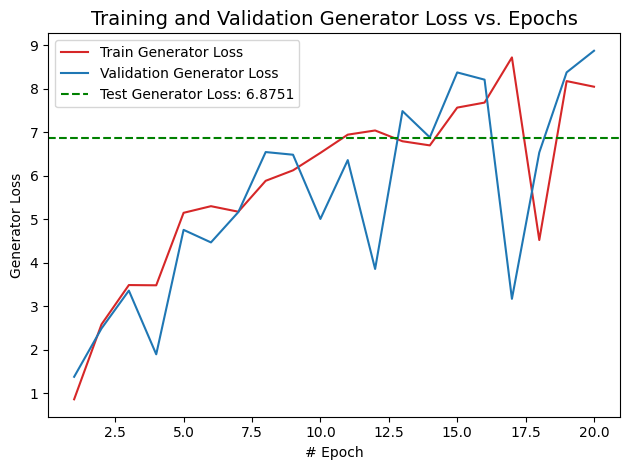

In [68]:
plot_train_valid_test(train_gen_loss_arr, val_gen_loss_arr, avg_gen_loss)

Took approx 30 min for one epoch

In [ ]:
# print('real loss:', real_loss_arr)
# print('fake_loss:', fake_loss_arr)
# print('gen loss:', gen_loss_arr)

real loss: [0.6926384568214417, 0.7660925388336182, 0.6561728715896606, 0.5598304271697998, 0.46303215622901917, 1.0720834732055664, 0.0036152778193354607, 0.02191822975873947, 0.14906074106693268, 0.5137878656387329, 0.579170823097229, 0.5198286771774292, 0.5335127711296082, 0.6748224496841431, 0.7189928889274597, 0.5909227132797241, 0.7409756183624268, 0.47483018040657043, 0.49755197763442993, 0.5170090198516846, 0.478449285030365, 0.4293334484100342, 0.5270951390266418, 0.4400210380554199, 0.4123081564903259, 0.2868313193321228, 0.33496832847595215, 0.27672192454338074, 0.3665046989917755, 0.19882884621620178, 0.13294418156147003, 0.2654171288013458, 0.4782065451145172, 0.2888663411140442]
fake_loss: [0.69410640001297, 0.6212223172187805, 0.6827373504638672, 0.6830984950065613, 0.48982441425323486, 0.0026722843758761883, 4.263914585113525, 2.0120279788970947, 0.6618999242782593, 0.4857944846153259, 0.35032281279563904, 0.30071642994880676, 0.4001666307449341, 0.4033140540122986, 0.4